In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'

    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    df['Начало нед'] = pd.to_datetime(df['Начало нед'])
    df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float)

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_39407/695145740.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ТВ реклама, руб'] = df['ТВ реклама, руб'].replace(' ', 0).astype(float)


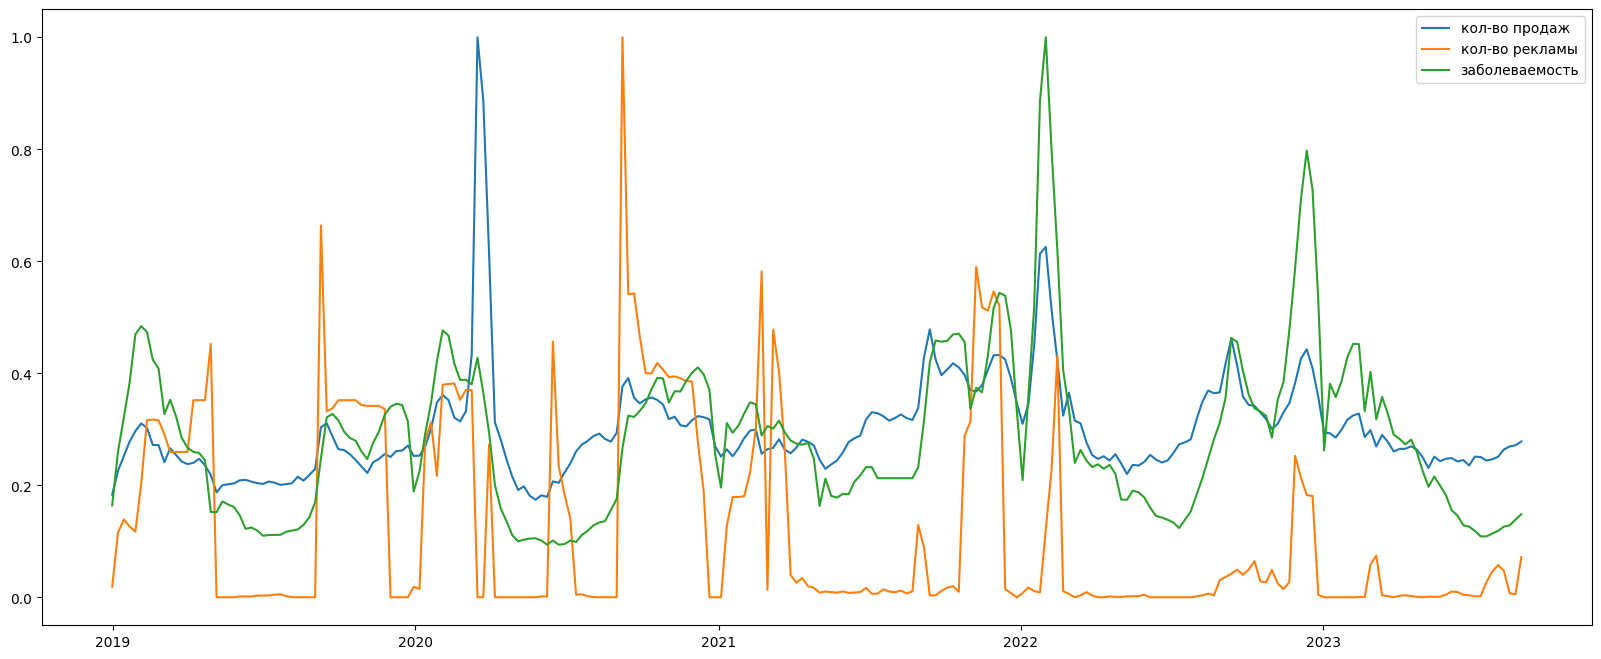

In [3]:
df['money'] = df['ТВ реклама, руб'] + df['интернет реклама, руб']

plt.figure(figsize=(20, 8))

cur_df = df[df.продажи.notna()]
plt.plot(cur_df['Начало нед'], cur_df['продажи'] / cur_df['продажи'].max())
plt.plot(cur_df['Начало нед'], cur_df['money'] / cur_df['money'].max())
plt.plot(cur_df['Начало нед'], cur_df['заболеваемость'] / cur_df['заболеваемость'].max())

plt.legend(['кол-во продаж', 'кол-во рекламы', 'заболеваемость'])

In [4]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    # week_info_dict = week_info.to_dict()
    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df['week_sum'] -= df['продажи'].shift(-i)
        df['week_count'] -= 1
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)
    df['feature_last_10_wordstat'] = df['wordstat'].shift(1).rolling(window=10).mean()

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)

In [5]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [6]:
i = 1

cur_df = df.drop([43-i, 44-i, 45-i, 46-i])

cur_df.iloc[35:45]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,feature_mean_week_0,feature_mean_week_norm_0,feature_mean_week_1,feature_mean_week_norm_1,feature_mean_week_2,feature_mean_week_norm_2,feature_mean_week_3,feature_mean_week_norm_3,feature_mean_week_4,feature_mean_week_norm_4,feature_mean_week_5,feature_mean_week_norm_5,feature_mean_week_6,feature_mean_week_norm_6,feature_mean_week_7,feature_mean_week_norm_7,feature_mean_week_8,feature_mean_week_norm_8,feature_mean_week_9,feature_mean_week_norm_9,feature_mean_week_10,feature_mean_week_norm_10,feature_mean_week_11,feature_mean_week_norm_11,feature_mean_week_12,feature_mean_week_norm_12,feature_mean_week_13,feature_mean_week_norm_13,feature_mean_week_14,feature_mean_week_norm_14,feature_mean_week_15,feature_mean_week_norm_15,feature_mean_week_16,feature_mean_week_norm_16,feature_mean_week_17,feature_mean_week_norm_17,feature_mean_week_18,feature_mean_week_norm_18,feature_mean_week_19,feature_mean_week_norm_19,feature_mean_week_20,feature_mean_week_norm_20,feature_mean_week_21,feature_mean_week_norm_21,feature_mean_week_22,feature_mean_week_norm_22,feature_mean_week_23,feature_mean_week_norm_23,feature_mean_week_24,feature_mean_week_norm_24,feature_mean_week_25,feature_mean_week_norm_25,feature_mean_week_26,feature_mean_week_norm_26,feature_mean_week_27,feature_mean_week_norm_27,feature_mean_week_28,feature_mean_week_norm_28,feature_illnesses,feature_last_10_wordstat,feature_week,feature_month_diff_1,feature_month_diff_5,feature_month_diff_9,feature_month_diff_13,feature_big_diff_7_weeks,feature_big_diff_13_weeks,feature_big_diff_20_weeks
35,1.153911,1.198256,1.168121,1.063807,1.041831,1.101161,1.437052,3.317014,2.94215,2.031747,1.036034,0.935861,0.817167,0.714386,0.63576,0.656709,0.601863,0.577916,0.603783,0.59482,0.686515,0.677927,0.738601,0.792704,0.863696,0.904703,0.926049,0.955059,0.969565,86433442.452,1.263607,82005612.609375,1.198875,76711288.891125,1.121475,64609863.1815,0.944559,68059184.97,0.994986,61986115.571625,0.906201,65146885.894125,0.95241,60828150.81525,0.889273,57498727.062,0.840598,57704078.08725,0.8436,58905852.2745,0.86117,58913969.942625,0.861288,58212600.17475,0.851035,54057471.38925,0.790289,49210200.8895,0.719425,52455173.97225,0.766864,52426663.435125,0.766448,53960882.7345,0.788877,56086527.60375,0.819953,55695405.82725,0.814235,55648499.33475,0.813549,56787324.517875,0.830198,59068858.881375,0.863553,60064208.358,0.878104,59491742.590875,0.869735,59243130.956625,0.8661,61869099.009375,0.904491,64827220.77825,0.947737,66589585.579125,0.973501,1077699,82658.940,5,1.112652,1.059214,1.095255,0.883114,1.154281,1.290797,0.993162
36,1.03843,1.012315,0.921914,0.902869,0.954286,1.245374,2.874583,2.549719,1.760748,0.897846,0.811034,0.708171,0.619099,0.550961,0.569115,0.521585,0.500832,0.523249,0.515482,0.594946,0.587503,0.640084,0.686971,0.748494,0.784032,0.80253,0.827671,0.840243,0.812691,82005612.609375,1.038966,76711288.891125,0.97189,64609863.1815,0.818572,68059184.97,0.862273,61986115.571625,0.78533,65146885.894125,0.825375,60828150.81525,0.770659,57498727.062,0.728477,57704078.08725,0.731079,58905852.2745,0.746305,58913969.942625,0.746408,58212600.17475,0.737522,54057471.38925,0.684879,49210200.8895,0.623466,52455173.97225,0.664578,52426663.435125,0.664217,53960882.7345,0.683655,56086527.60375,0.710586,55695405.82725,0.70563,55648499.33475,0.705036,56787324.517875,0.719464,59068858.881375,0.74837,60064208.358,0.760981,59491742.590875,0.753728,59243130.956625,0.750578,61869099.009375,0.783848,64827220.77825,0.821325,66589585.579125,0.843654,65846186.2275,0.834235,1307649,84954.660,6,1.378577,1.007155,1.128655,0.844563,1.328336,1.56707,1.119489
37,0.974851,0.887796,0.869456,0.91897,1.199286,2.768202,2.45536,1.695587,0.864619,0.7810

In [7]:
test_size = 0.35 # 0.4

from sklearn.model_selection import train_test_split

all_models = []
all_metrics = []
all_preds = []
for i in range(1, 30):
    print(f'Предсказываение на {i} недель вперед')

    cur_df = df[df[f'target_{i}'].notna()]

    cur_df = cur_df.drop([43-i, 44-i, 45-i, 46-i])

    # for j in range(1, 30):
    #     if abs(i - j) >= 20:
    #         cur_df = cur_df.drop([f'feature_mean_week_{j-1}', f'feature_mean_week_norm_{j-1}'], axis=1)

    # train_data, valid_data = train_test_split(cur_df, test_size=test_size, random_state=42)

    train_data, valid_data = cur_df[:int(len(cur_df) * (1-test_size))], cur_df[int(len(cur_df) * (1-test_size)):]

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=2,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',

        random_state=42,
        thread_count=5
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
0:	learn: -0.0042600	test: 0.0006819	best: 0.0006819 (0)	total: 54.5ms	remaining: 2m 43s
1000:	learn: 0.5031928	test: 0.1990772	best: 0.1996901 (954)	total: 299ms	remaining: 598ms
2000:	learn: 0.5787220	test: 0.2236046	best: 0.2258825 (1603)	total: 533ms	remaining: 266ms
2999:	learn: 0.6229295	test: 0.2368973	best: 0.2377235 (2820)	total: 760ms	remaining: 0us

bestTest = 0.2377234794
bestIteration = 2820

Shrink model to first 2821 iterations.
R2: 0.23772
MAPE: 0.04605

Предсказываение на 2 недель вперед
0:	learn: -0.0030897	test: -0.0036633	best: -0.0036633 (0)	total: 287us	remaining: 864ms
1000:	learn: 0.5815857	test: 0.2643779	best: 0.2666791 (883)	total: 234ms	remaining: 466ms
2000:	learn: 0.6369397	test: 0.2662433	best: 0.2732373 (1828)	total: 452ms	remaining: 226ms
2999:	learn: 0.6864758	test: 0.2687341	best: 0.2732373 (1828)	total: 669ms	remaining: 0us

bestTest = 0.2732372821
bestIteration = 1828

Shrink model to first 1829 iterations.
R2: 0.2

In [ ]:
with open("models.pkl", "wb") as file:
    pickle.dump(all_models, file)

In [ ]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[-1].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
37,feature_mean_week_norm_18,10.389872
67,feature_big_diff_20_weeks,8.462882
39,feature_mean_week_norm_19,7.038690
41,feature_mean_week_norm_20,5.729252
57,feature_mean_week_norm_28,4.812632
...,...,...
24,feature_mean_week_12,0.128833
52,feature_mean_week_26,0.058630
15,feature_mean_week_norm_7,0.017252
53,feature_mean_week_norm_26,0.014747


In [ ]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.6462
MAPE: 0.1319


R2: 0.42683
MAPE: 0.10619

In [ ]:
cur_df = df[df[f'target_29'].notna()]


preds = [all_models[i].predict(cur_df[[col for col in cur_df.columns if 'feature' in col]].iloc[[-10]])[0] for i in range(29)]

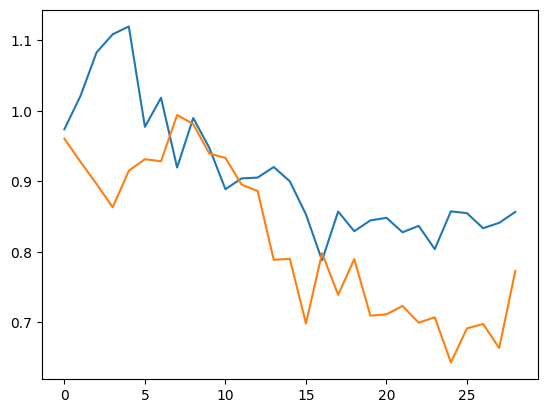

In [ ]:
plt.plot([cur_df.iloc[-5][f'target_{i}'] for i in range(1, 30)])
plt.plot(preds)

-----

In [ ]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pickle

pd.options.display.max_columns = 200

In [ ]:
all_models = pickle.load(open('models.pkl', 'rb'))

In [ ]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя']==53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [ ]:
df[df['год'].notna()]

,год,неделя,Начало нед,продажи,"Продажи, рубли","Продажи, упаковки","Продажи, рубли","Продажи, рубли","раствор 0.01 % 150 мл N1, руб","раствор 0.01 % 50 мл N1, руб","раствор 0.01 % 500 мл N1, руб","раствор 0.01 % 150 мл N1, упаковки","раствор 0.01 % 50 мл N1, упаковки","раствор 0.01 % 500 мл N1, упаковки",Дистрибуция Мирамистин,Выписки,заболеваемость,Индекс цены,Развитие Дженериков \n(средняя дистрибуция),Развитие Дженериков \n(кол-во брендов),"(1)\nТВ, trp\n(Ж 30-60 ВС)","(1)\nТВ, рубли","(1)\nТВ, охват 5+\n(Ж 30-60 ВС)","(2)\nТВ, trp\n(Ж 30-60 ВС)","(2)\nТВ, рубли","(2)\nТВ, охват 5+\n(Ж 30-60 ВС)","(3)\nТВ, trp\n(Ж 30-60 ВС)","(3)\nТВ, рубли","(3)\nТВ, охват 5+\n(Ж 30-60 ВС)","(4)\nТВ, trp\n(Ж 30-60 ВС)","(4)\nТВ, рубли","(4)\nТВ, охват 5+\n(Ж 30-60 ВС)","(тотал)\nТВ, trp\n(Ж 30-60 ВС)","ТВ реклама, руб","(тотал)\nТВ, охват 5+\n(Ж 30-60 ВС)","интернет реклама, руб","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, количество выходов",wordstat,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб",...,"ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, trp\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, охват 5+\n(Ж 30-60 ВС)","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","ТВ, рубли","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","Диджитал, руб","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","ТВ спонсорство, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","OOH, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли","Радио, рубли",Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого,Итого
5,2019,1,2018-12-31 00:00:00,41535567.339,0,114621.15,41535567.339,0,0,0,0,0,0,0,0.92107,99698.595433,508956,1.54132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,1057612.5,0,0,0,0,0,0,0,0,0

In [ ]:
def create_features(df):

    week_info = df.groupby('неделя')['продажи'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    for i in range(29):
        df[f'target_{i+1}'] = df['продажи'].shift(-i) / df['продажи'].shift(1)

    for i in range(29):
        df['tmp'] = df['неделя'] + i
        df = df.merge(week_info, how='left', right_index=True, left_on='tmp')
        df[f'feature_mean_week_{i}'] = df['week_sum'] / df['week_count']
        df[f'feature_mean_week_norm_{i}'] = df[f'feature_mean_week_{i}'] / df['продажи'].shift(1)
        df.drop(['week_sum', 'week_count'], axis=1, inplace=True)

    df['feature_illnesses'] = df['заболеваемость'].shift(1)
    df['feature_last_10_wordstat'] = df['wordstat'].shift(1).rolling(window=10).mean()

    df['feature_week'] = df['неделя']

    for i in range(1, 16, 4):
        df[f'feature_month_diff_{i}'] = df['продажи'].shift(i) / df['продажи'].shift(i+4)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['продажи'].shift(1) / df['продажи'].shift(i)

    return df

df = create_features(df)
df = df.reset_index(drop=True)

In [ ]:
max_id = df[df['target_1'].notna()].index.max()

preds = [df.iloc[max_id]['продажи'] * model.predict(df[model.feature_names_].iloc[max_id+1]) for model in all_models]

sample = pd.DataFrame({
    'week': ['04.09.2023', '11.09.2023', '18.09.2023', '25.09.2023', '02.10.2023', '09.10.2023', '16.10.2023', '23.10.2023', '30.10.2023', '06.11.2023', '13.11.2023', '20.11.2023', '27.11.2023', '04.12.2023', '11.12.2023', '18.12.2023', '25.12.2023', '01.01.2024', '08.01.2024', '15.01.2024', '22.01.2024', '29.01.2024', '05.02.2024', '12.02.2024', '19.02.2024', '26.02.2024', '04.03.2024', '11.03.2024', '18.03.2024'],
    'revenue': preds
})

sample.to_csv('answer_5.csv', index=False)

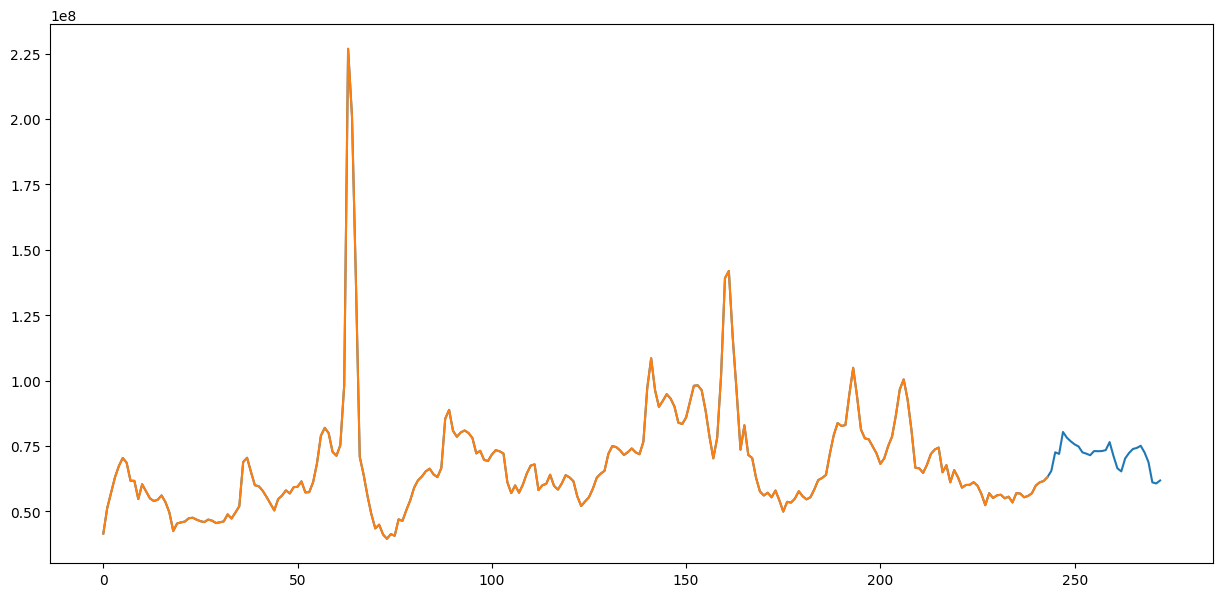

In [ ]:
prev = df[df['продажи'].notna()]['продажи'].tolist()

plt.figure(figsize=(15, 7))

plt.plot(prev + preds)
plt.plot(prev)

plt.legend(['предсказание', 'исторические данные'])